In [1]:
import pandas as pd
import numpy as np
import math
from random import uniform
import matplotlib.pyplot as plt

In [2]:
from neural_network import neural_network as net

In [3]:
TRAIN_DATA_X = 'data/x_train.csv'
TRAIN_DATA_Y = 'data/y_train.csv'
TEST_DATA_X = 'data/x_test.csv'
TEST_DATA_Y = 'data/y_test.csv'

NORMALIZE_COLUMNS = ['NumDeath', 'NumInjured', 'NumVehInteraction']

def normalize_df(df_base, columns):
    df = df_base.copy()
    for column in columns:
        df[column] = normalize_max_unknown(df[column])
    
    return df

def normalize_max_unknown(vector):
    min = np.min(vector)
    max = np.max(vector)
        
    return [(x - float(min)) / (float(max) - float(min)) for x in vector]

In [4]:
train_x_df = pd.read_csv(TRAIN_DATA_X)
train_y_df = pd.read_csv(TRAIN_DATA_Y)

df_y = train_y_df['Classification']
df_x = train_x_df[['NumDeath', 'NumInjured', 'NumPedestrianVictim', 'NumVehInteraction', 'PassengerInjured',
                   'PassengerKilled', 'PedestrianInjured','PedestrianKilled','DriversInjured','DriversKilled']]

df_x = normalize_df(df_x, NORMALIZE_COLUMNS)

dataset_df = pd.concat([df_x, df_y], axis=1)

In [5]:
#OneHotEncoding the Classification [1/2/3]
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(df_y.values.reshape(-1,1))

data_array_y = enc.transform(df_y.values.reshape(-1,1)).toarray()

In [6]:
#declaring the classification and running the neural network classification
neural_net_go_a = net.NeuralNetwork([10,4,3,3],['Sigmoid','Sigmoid','Sigmoid'])
neural_net_go_a.train(df_x.values, data_array_y, epochs=500, train_method='sequential')

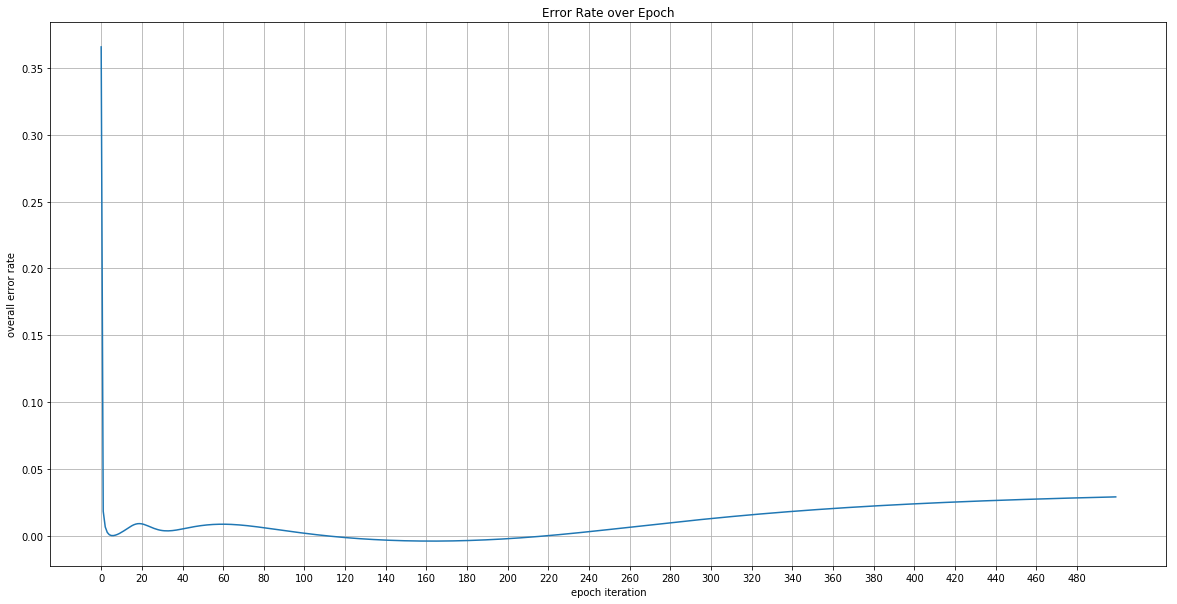

In [7]:
def plot_error_rate(overall_error_list):
    #Size
    fig = plt.figure(figsize=(20,10))
    
    #Fixing X-Ticks
    y = np.array(overall_error_list)
    x = np.arange(y.shape[0])
    frequency = 20
    plt.xticks(x[::frequency],x[::frequency])
    
    #Labels
    plt.xlabel('epoch iteration')
    plt.ylabel('overall error rate')
    plt.grid(True)
    plt.title('Error Rate over Epoch')
    plt.plot(x, y)
    plt.show()
    
plot_error_rate(neural_net_go_a.overall_error_list) 

In [8]:
#One hot classification
dataset_cls_dummies = pd.get_dummies(dataset_df['Classification'], prefix='cls')
dataset_df = pd.concat([dataset_df, dataset_cls_dummies], axis=1)

#Partition dataset based on classification
class_one_df = dataset_df.loc[dataset_df['Classification'] == 1]
class_two_df = dataset_df.loc[dataset_df['Classification'] == 2]    
class_three_df = dataset_df.loc[dataset_df['Classification'] == 3]

#Extract classification
class_one_y = class_one_df[['cls_1', 'cls_2', 'cls_3']].values
class_two_y = class_two_df[['cls_1', 'cls_2', 'cls_3']].values
class_three_y = class_three_df[['cls_1', 'cls_2', 'cls_3']].values

#Remove classification column
class_one_df = class_one_df.drop(['Classification', 'cls_1', 'cls_2', 'cls_3'], axis=1)
class_two_df = class_two_df.drop(['Classification', 'cls_1', 'cls_2', 'cls_3'], axis=1)
class_three_df = class_three_df.drop(['Classification', 'cls_1', 'cls_2', 'cls_3'], axis=1)

In [9]:
#Convert dataframes to lists
df_values_arr = [class_one_df.values, class_two_df.values, class_three_df.values]

#Create and train autoencoder model for each dataset partition
activation_scheme = ['Sigmoid', 'Sigmoid']

#Classification 1 Auto Encoder
data_arr = class_one_df.values

features_len = len(data_arr[0])
latent_len = features_len - 2
topology = [features_len, latent_len, features_len]

class_one_encoder = net.NeuralNetwork(topology, activation_scheme)

class_one_encoder.train(data_arr, data_arr, epochs=300)
# class_one_encoder.run(data_arr[1], data_arr[1])

#Classification 2 Auto Encoder
data_arr = class_two_df.values

features_len = len(data_arr[0])
latent_len = features_len - 2
topology = [features_len, latent_len, features_len]

class_two_encoder = net.NeuralNetwork(topology, activation_scheme)

class_two_encoder.train(data_arr, data_arr, epochs=300)
# class_two_encoder.run(data_arr[1], data_arr[1])

#Classification 3 Auto Encoder
data_arr = class_three_df.values

features_len = len(data_arr[0])
latent_len = features_len - 2
topology = [features_len, latent_len, features_len]

class_three_encoder = net.NeuralNetwork(topology, activation_scheme)

class_three_encoder.train(data_arr, data_arr, epochs=300)
# class_three_encoder.run(data_arr[1], data_arr[1])

In [10]:
# Experiment B Classification Neural Net
latent_layers = np.concatenate((class_one_encoder.latent_layers, class_two_encoder.latent_layers, class_three_encoder.latent_layers))
exp_b_y = np.concatenate((class_one_y, class_two_y, class_three_y))

# print('Latent Layers: %s' % str(latent_layers[0]))
# print('Classification: %s' % str(exp_b_y))

exp_b_topology = [8, 5, 3]
exp_b_activation = ['Sigmoid', 'Sigmoid']

neural_net_go_b = net.NeuralNetwork(exp_b_topology, exp_b_activation)
neural_net_go_b.train(latent_layers, exp_b_y, epochs=300, train_method='sequential')

In [11]:
# Validate against test dataset
test_x_df = pd.read_csv(TEST_DATA_X)
test_y_df = pd.read_csv(TEST_DATA_Y)

test_df_y = test_y_df['Classification']
test_df_x = test_x_df[['NumDeath', 'NumInjured', 'NumPedestrianVictim', 'NumVehInteraction', 'PassengerInjured',
                       'PassengerKilled', 'PedestrianInjured','PedestrianKilled','DriversInjured','DriversKilled']]

test_df_x = normalize_df(test_df_x, NORMALIZE_COLUMNS)
test_x = test_df_x.values
test_y = pd.get_dummies(test_df_y, prefix='cls').values

features_len = len(test_x[0])
latent_len = features_len - 2
topology = [features_len, latent_len, features_len]

test_encoder = net.NeuralNetwork(topology, activation_scheme)
test_encoder.train(test_x, test_x, epochs=300)

test_latent = test_encoder.latent_layers

for i in range(len(test_y)):
    neural_net_go_b.run(test_latent[i], test_y[i])

Actual: [1 0 0]
Guess: [[ 0.04257326  0.62164777  0.29963524]]
Actual: [1 0 0]
Guess: [[ 0.04257595  0.62164273  0.29962908]]
Actual: [1 0 0]
Guess: [[ 0.0425788   0.62163739  0.29962256]]
Actual: [1 0 0]
Guess: [[ 0.04258169  0.62163196  0.29961593]]
Actual: [0 0 1]
Guess: [[ 0.03267846  0.6424072   0.32588247]]
Actual: [1 0 0]
Guess: [[ 0.04258458  0.62162654  0.29960931]]
Actual: [0 1 0]
Guess: [[ 0.01013516  0.72575355  0.45059398]]
Actual: [1 0 0]
Guess: [[ 0.04258552  0.62162477  0.29960715]]
Actual: [0 1 0]
Guess: [[ 0.01013558  0.72575083  0.45058936]]
Actual: [1 0 0]
Guess: [[ 0.042586    0.62162389  0.29960606]]
Actual: [1 0 0]
Guess: [[ 0.0425861   0.6216237   0.29960584]]
Actual: [1 0 0]
Guess: [[ 0.04258725  0.62162154  0.2996032 ]]
Actual: [0 1 0]
Guess: [[ 0.01013636  0.72574582  0.45058087]]
Actual: [0 1 0]
Guess: [[ 0.01611478  0.69440915  0.39987463]]
Actual: [1 0 0]
Guess: [[ 0.04255415  0.62168362  0.29967904]]
Actual: [0 1 0]
Guess: [[ 0.00803145  0.74064183  0.476

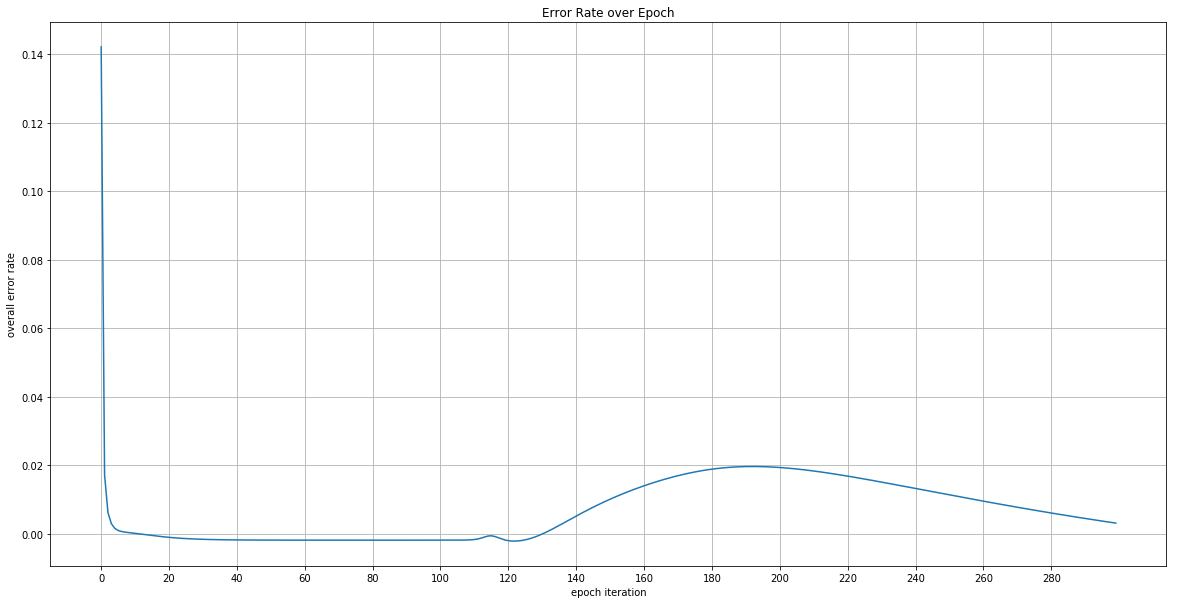

In [12]:
plot_error_rate(neural_net_go_b.overall_error_list) 

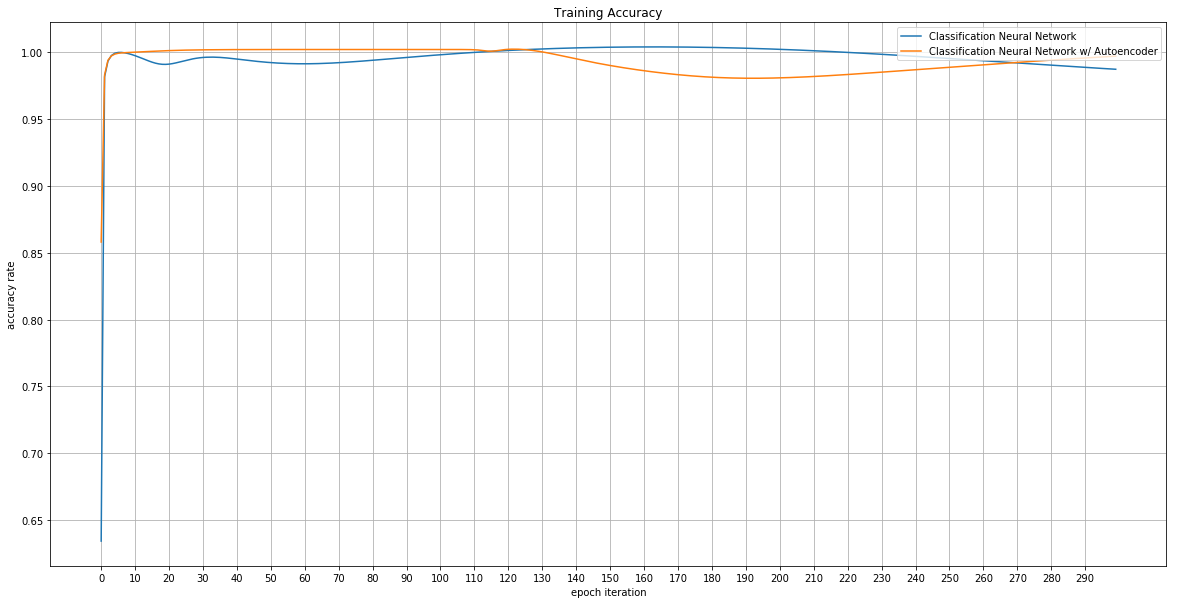

In [14]:
def plot_comparison(error_rate_A, error_rate_B):
    #Size
    fig = plt.figure(figsize=(20,10))
    
    #Fixing X-Ticks
    
    accuracy_A = 1 - np.array(error_rate_A)
    #print(accuracy_A)
    accuracy_B = 1 - np.array(error_rate_B)
    
    y1 = np.array(accuracy_A)
    x = np.arange(y1.shape[0])
    y2 = np.array(accuracy_B)
    
    frequency = 10
    plt.xticks(x[::frequency],x[::frequency])
    
    #plotting the two lines
    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.legend(['Classification Neural Network', 'Classification Neural Network w/ Autoencoder'], loc='upper right')
    
    #Labels
    plt.xlabel('epoch iteration')
    plt.ylabel('accuracy rate')
    plt.grid(True)
    plt.title('Training Accuracy')
    plt.show()
    
plot_comparison(neural_net_go_a.overall_error_list[0:len(neural_net_go_b.overall_error_list)], neural_net_go_b.overall_error_list)